In [ ]:
# ── Cell 1: Setup & Imports ──────────────────────────────────────────────────
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)

print("TensorFlow version:", tf.__version__)
print("GPUs available:", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1
TensorFlow version: 2.17.1


In [ ]:
# ── Cell 2: Dataset Path & Structure ─────────────────────────────────────────
# Kaggle dataset: melanoma-skin-cancer-dataset-of-10000-images
# Structure: melanoma_cancer_dataset / train|test / benign|malignant
DATASET_PATH = '/kaggle/input/melanoma-skin-cancer-dataset-of-10000-images/melanoma_cancer_dataset'
train_dir = os.path.join(DATASET_PATH, 'train')
test_dir  = os.path.join(DATASET_PATH, 'test')

VALID_EXTS = ('.jpg', '.jpeg', '.png', '.bmp')

def count_images(directory):
    """Return {class_name: image_count} for a split directory."""
    counts = {}
    for cls in sorted(os.listdir(directory)):
        cls_path = os.path.join(directory, cls)
        if os.path.isdir(cls_path):
            counts[cls] = sum(1 for f in os.listdir(cls_path)
                              if f.lower().endswith(VALID_EXTS))
    return counts

for split, d in [('Train', train_dir), ('Test', test_dir)]:
    print(f"\n{split} directory ({d}):")
    for cls, cnt in count_images(d).items():
        print(f"  {cls}: {cnt} images")


Dataset contents:
- test
- train

Training directory classes:
- benign: 5000 images
- malignant: 4605 images

Testing directory classes:
- benign: 500 images
- malignant: 500 images


Sample images from class: benign


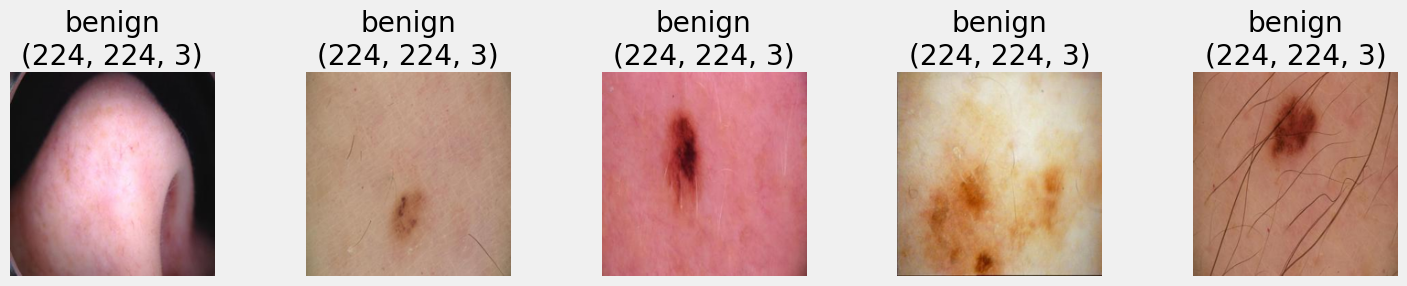

Sample images from class: malignant


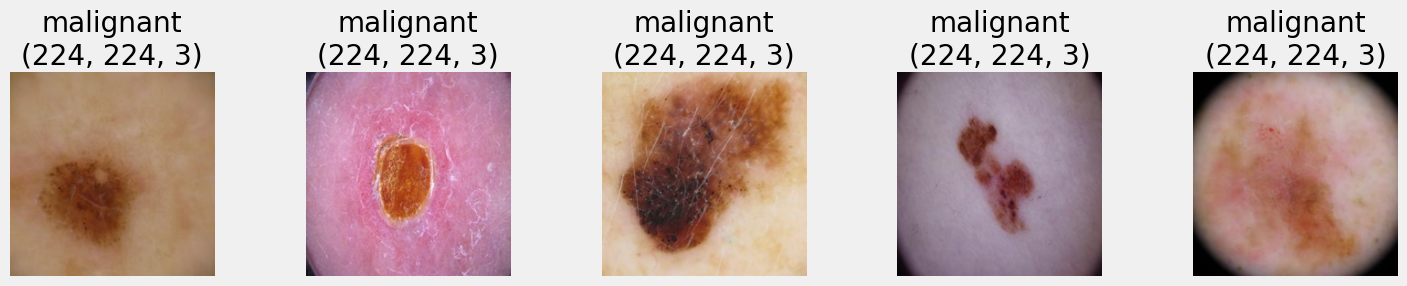

In [ ]:
# ── Cell 3: Sample Images ─────────────────────────────────────────────────────
def display_sample_images(directory, n=5):
    """Display n sample images per class from a split directory."""
    classes = sorted([d for d in os.listdir(directory)
                      if os.path.isdir(os.path.join(directory, d))])
    fig, axes = plt.subplots(len(classes), n, figsize=(n * 3, len(classes) * 3))
    if len(classes) == 1:
        axes = [axes]

    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(VALID_EXTS)][:n]
        for j, fname in enumerate(files):
            img = Image.open(os.path.join(cls_path, fname)).resize((224, 224)).convert('RGB')
            axes[i][j].imshow(img)
            axes[i][j].set_title(cls)
            axes[i][j].axis('off')
        # Hide unused subplots in this row
        for j in range(len(files), n):
            axes[i][j].axis('off')

    plt.suptitle('Sample Training Images', fontsize=14)
    plt.tight_layout()
    plt.show()

display_sample_images(train_dir)


Analyzing training dataset...


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


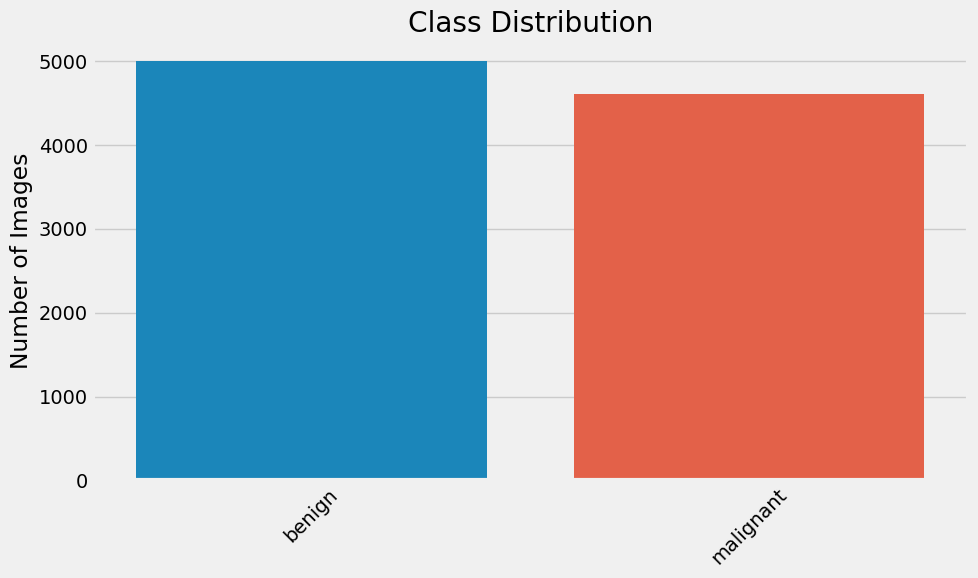

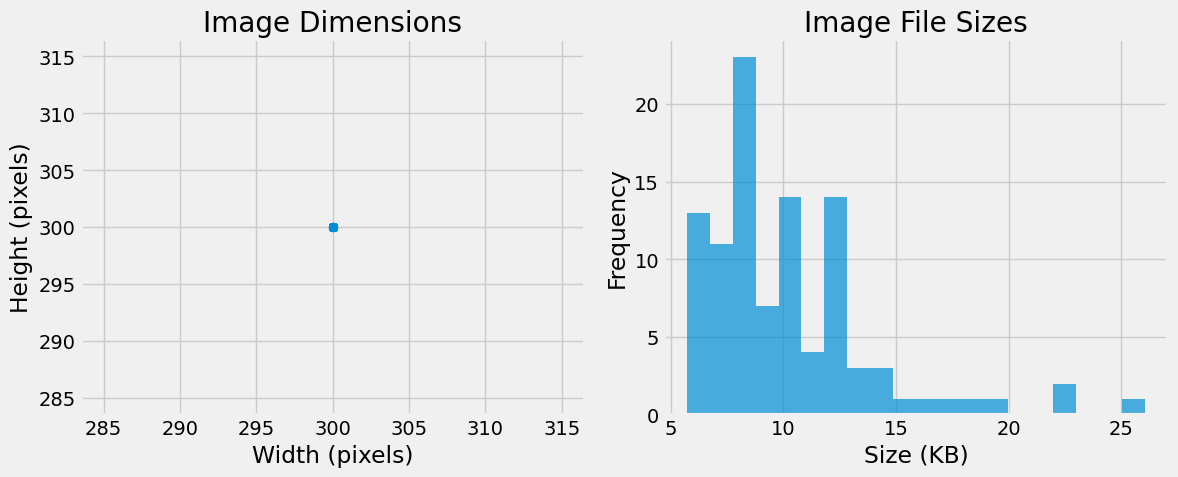


Class distribution percentages:
- benign: 52.06%
- malignant: 47.94%


In [ ]:
# ── Cell 4: Dataset Analysis ──────────────────────────────────────────────────
def analyze_dataset(directory, label):
    """Analyse class distribution and sample image dimensions."""
    class_counts = count_images(directory)
    total = sum(class_counts.values())

    # Class distribution bar chart
    plt.figure(figsize=(7, 4))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette='Set2')
    plt.title(f'Class Distribution – {label}')
    plt.ylabel('Number of Images')
    plt.tight_layout()
    plt.show()

    print(f"{label} class distribution:")
    for cls, cnt in class_counts.items():
        print(f"  {cls}: {cnt:,}  ({cnt / total * 100:.1f} %)")

    # Sample image width/height distribution
    shapes = []
    for cls in class_counts:
        cls_path = os.path.join(directory, cls)
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(VALID_EXTS)]
        sample = np.random.choice(files, min(50, len(files)), replace=False)
        for f in sample:
            w, h = Image.open(os.path.join(cls_path, f)).size
            shapes.append((w, h))

    shapes = np.array(shapes)
    plt.figure(figsize=(6, 4))
    plt.scatter(shapes[:, 0], shapes[:, 1], alpha=0.4, s=10)
    plt.title(f'Image Dimensions – {label}')
    plt.xlabel('Width (px)')
    plt.ylabel('Height (px)')
    plt.tight_layout()
    plt.show()

    return class_counts

train_counts = analyze_dataset(train_dir, 'Training')
test_counts  = analyze_dataset(test_dir,  'Test')


Examining image characteristics...


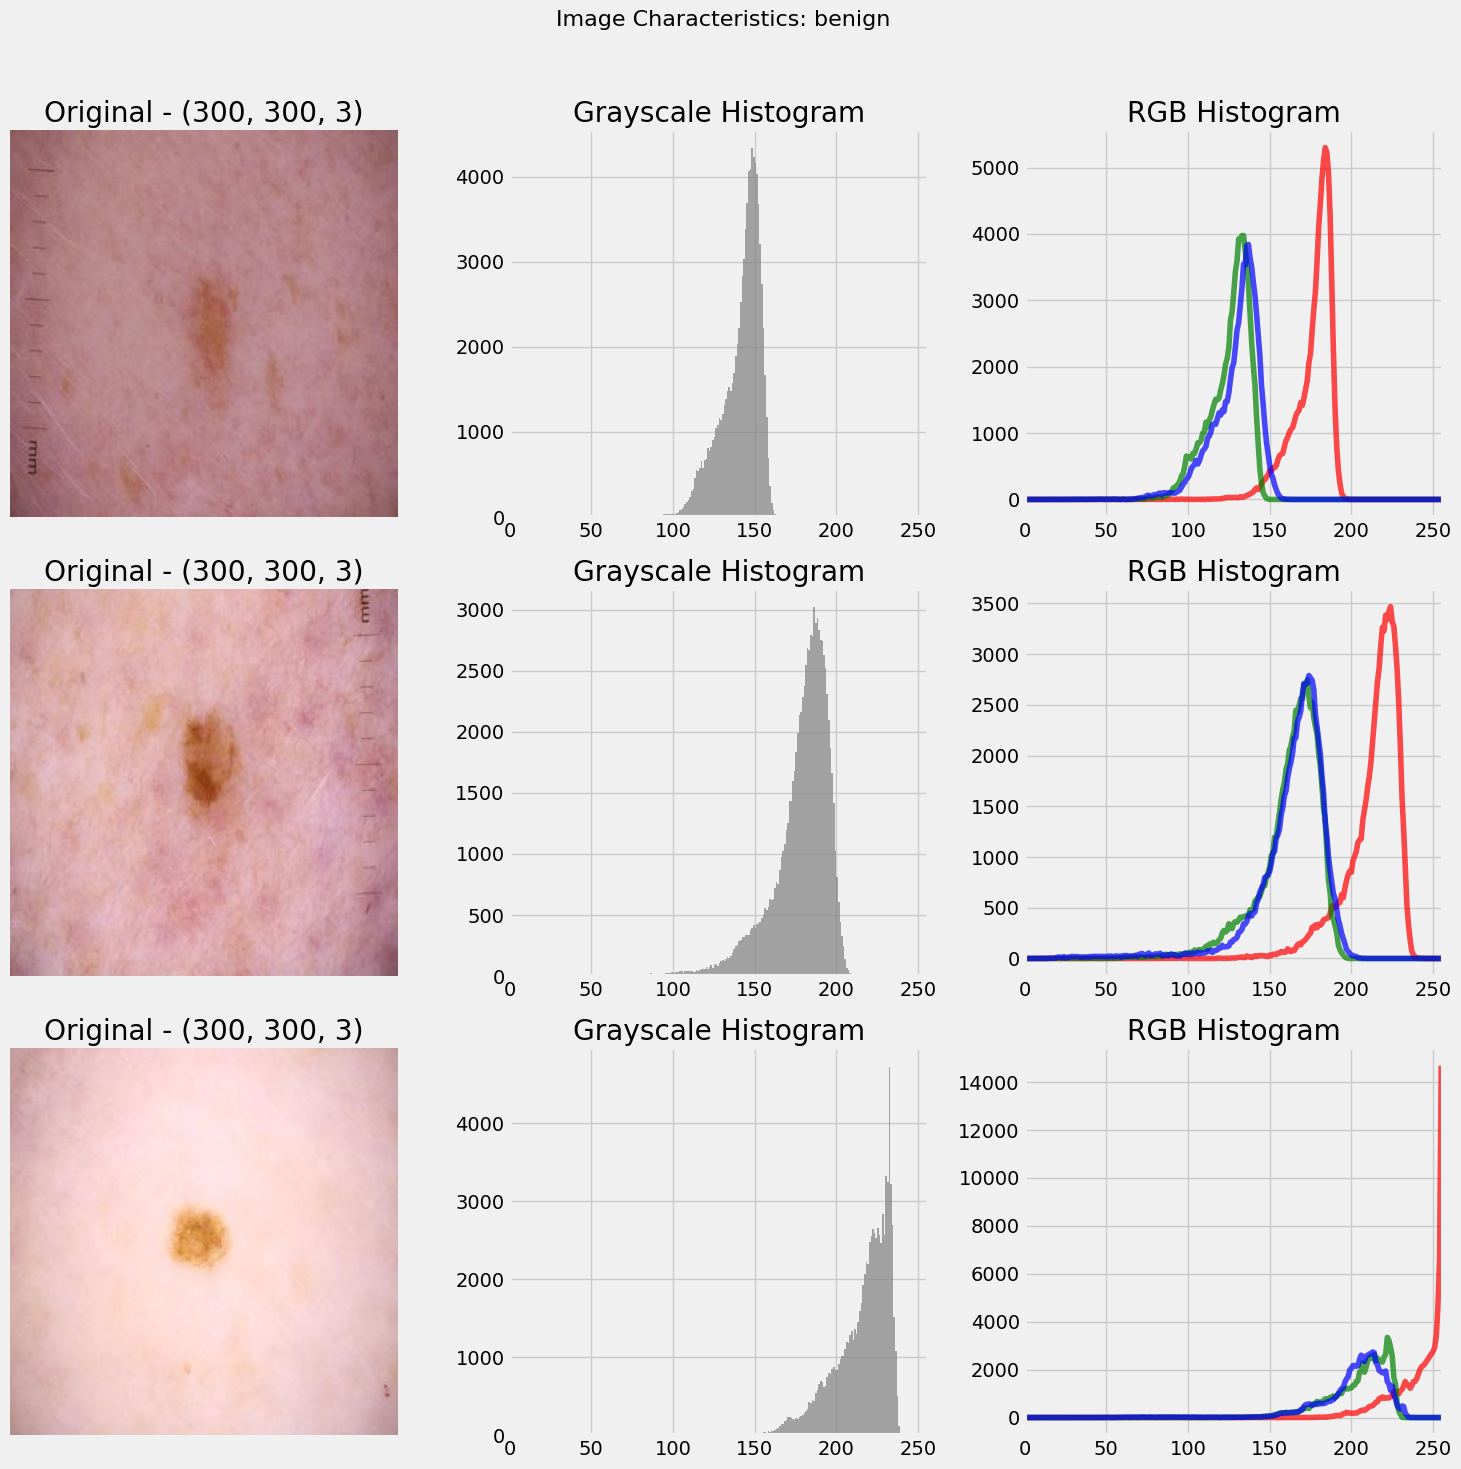

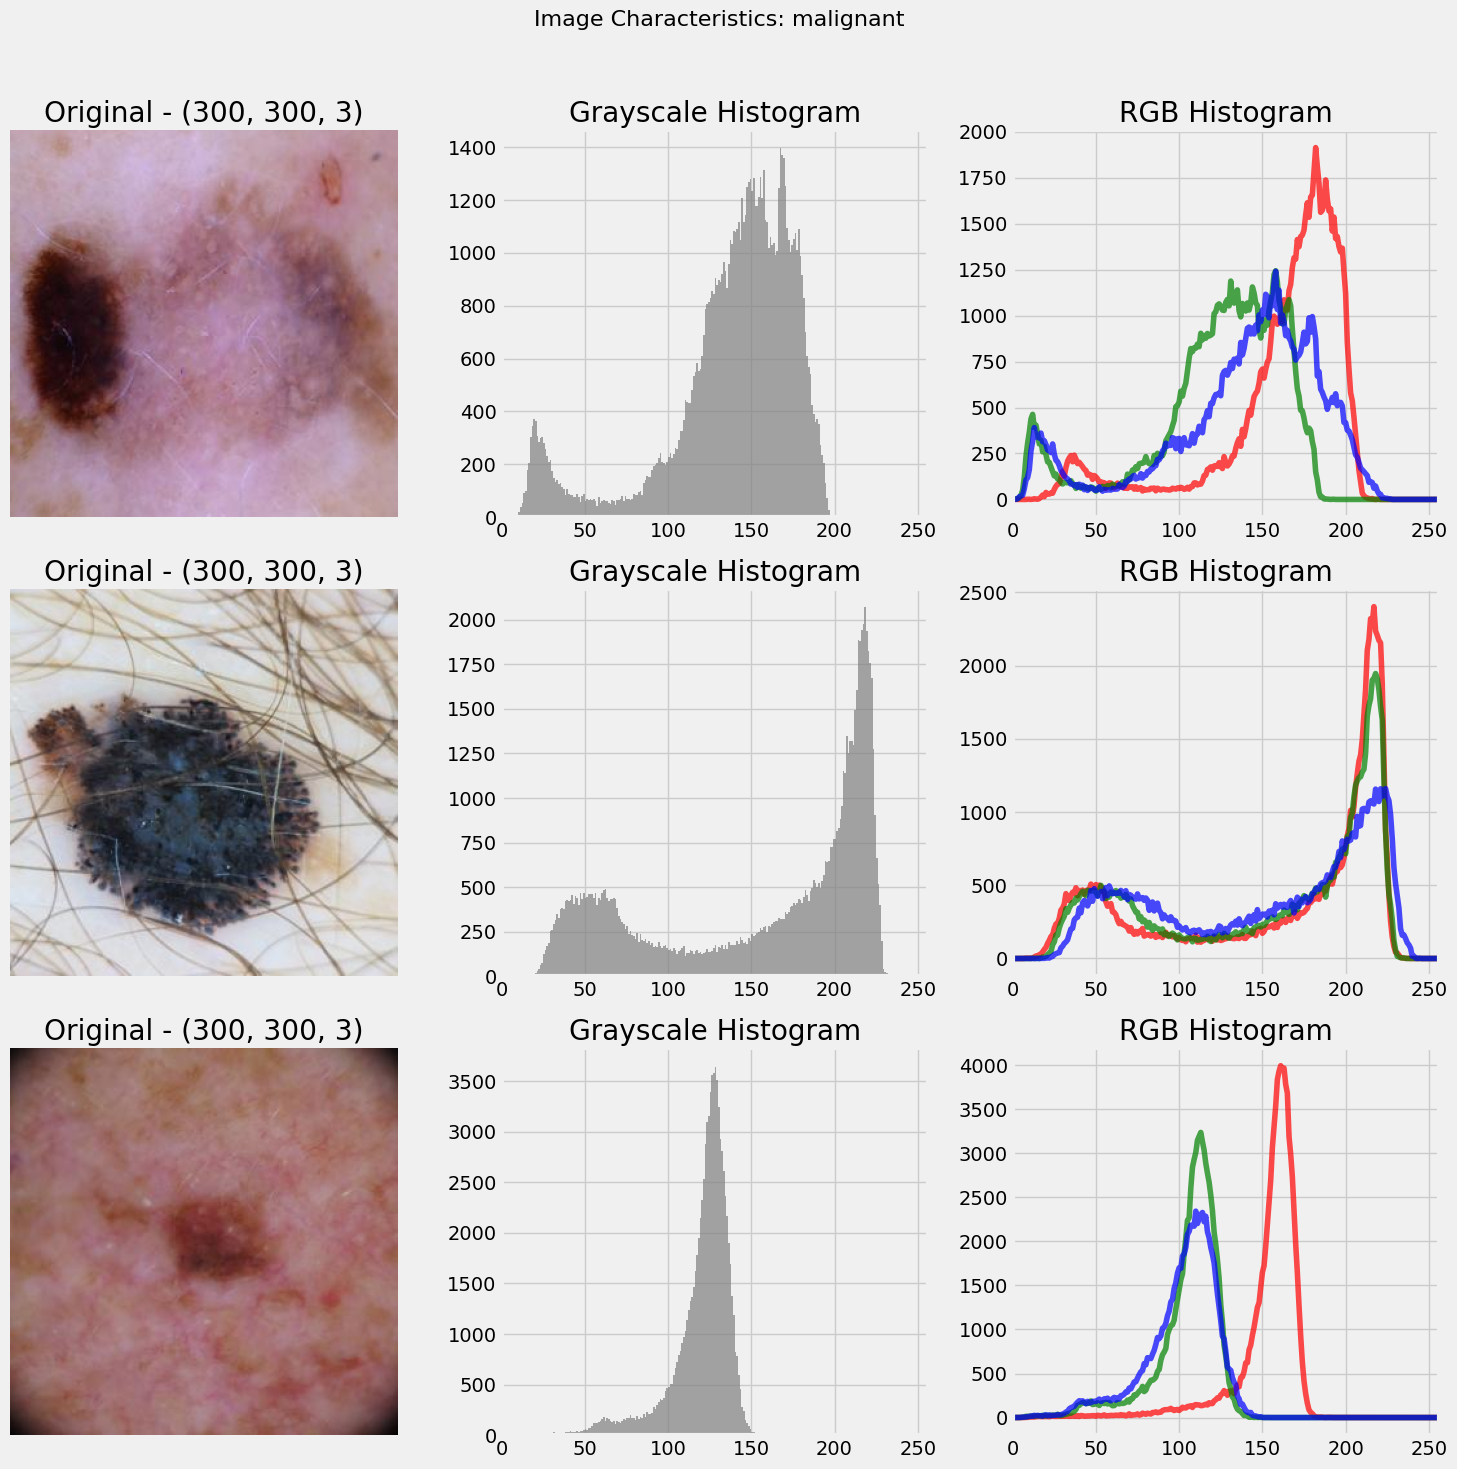

In [ ]:
# ── Cell 5: Image Characteristics ────────────────────────────────────────────
def examine_image_characteristics(directory, n_per_class=2):
    """Show original image, grayscale histogram, and RGB histogram per class."""
    classes = sorted([d for d in os.listdir(directory)
                      if os.path.isdir(os.path.join(directory, d))])

    for cls in classes:
        cls_path = os.path.join(directory, cls)
        files = [f for f in os.listdir(cls_path) if f.lower().endswith(VALID_EXTS)]
        samples = np.random.choice(files, min(n_per_class, len(files)), replace=False)

        fig, axes = plt.subplots(n_per_class, 3, figsize=(14, 4 * n_per_class))
        if n_per_class == 1:
            axes = [axes]

        for i, fname in enumerate(samples):
            img_bgr = cv2.imread(os.path.join(cls_path, fname))
            img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

            # Original
            axes[i][0].imshow(img_rgb)
            axes[i][0].set_title(f'{cls} – original  {img_rgb.shape[:2]}')
            axes[i][0].axis('off')

            # Grayscale histogram
            gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
            axes[i][1].hist(gray.ravel(), bins=256, range=(0, 256), color='gray', alpha=0.7)
            axes[i][1].set_title('Grayscale histogram')
            axes[i][1].set_xlim(0, 256)

            # RGB histogram
            for ch, color in enumerate(('r', 'g', 'b')):
                hist = cv2.calcHist([img_rgb], [ch], None, [256], [0, 256])
                axes[i][2].plot(hist, color=color, alpha=0.7)
            axes[i][2].set_title('RGB histogram')
            axes[i][2].set_xlim(0, 256)

        plt.suptitle(f'Image Characteristics – {cls}', fontsize=13)
        plt.tight_layout()
        plt.show()

print("Examining image characteristics (training set)…")
examine_image_characteristics(train_dir)


In [ ]:
# ── Cell 6: Build DataFrames ──────────────────────────────────────────────────
def create_dataframe(directory):
    """Return a DataFrame with columns [image_path, label] for a split directory."""
    paths, labels = [], []
    for cls in sorted(os.listdir(directory)):
        cls_path = os.path.join(directory, cls)
        if not os.path.isdir(cls_path):
            continue
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(VALID_EXTS):
                paths.append(os.path.join(cls_path, fname))
                labels.append(cls)
    df = pd.DataFrame({'image_path': paths, 'label': labels})
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
    return df

train_df = create_dataframe(train_dir)
test_df  = create_dataframe(test_dir)

print(f"Training: {len(train_df):,} images")
print(train_df['label'].value_counts())
print(f"\nTest: {len(test_df):,} images")
print(test_df['label'].value_counts())

# Class names (sorted so benign=0, malignant=1 — matches generator's alphabetical order)
CLASS_NAMES = sorted(train_df['label'].unique().tolist())
NUM_CLASSES = len(CLASS_NAMES)
print(f"\nClass names: {CLASS_NAMES}  (0=benign, 1=malignant)")


Creating training dataset DataFrame...
Training dataset: 9605 images
                                          image_path   label
0  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
1  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
2  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
3  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
4  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign

Training label distribution:
label
benign       5000
malignant    4605
Name: count, dtype: int64

Creating testing dataset DataFrame...
Testing dataset: 1000 images
                                          image_path   label
0  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
1  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
2  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
3  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign
4  /kaggle/input/melanoma-skin-cancer-dataset-of-...  benign

Testing label distribution:
labe

In [ ]:
# ── Cell 7: Global Hyperparameters ────────────────────────────────────────────
IMG_SIZE   = 224      # EfficientNetB3 native input size
BATCH_SIZE = 32
SEED       = 42
EPOCHS_FROZEN   = 25  # Phase 1: backbone frozen
EPOCHS_FINETUNE = 35  # Phase 2: top layers unfrozen (added on top of phase-1 epochs)

print(f"IMG_SIZE={IMG_SIZE}  BATCH_SIZE={BATCH_SIZE}  seed={SEED}")
print(f"Phase-1 epochs: {EPOCHS_FROZEN}   Phase-2 total epochs: {EPOCHS_FINETUNE}")


In [ ]:
# ── Cell 8: Train / Validation Split & Class Weights ────────────────────────
train_split, val_split = train_test_split(
    train_df,
    test_size=0.2,
    random_state=SEED,
    stratify=train_df['label']
)

print(f"Train split : {len(train_split):,} images")
print(train_split['label'].value_counts())
print(f"\nVal split   : {len(val_split):,} images")
print(val_split['label'].value_counts())

# ─── Class weights (handles class imbalance) ─────────────────────────────────
# flow_from_dataframe with class_mode='binary' assigns labels alphabetically:
#   benign → 0,  malignant → 1
unique_labels  = np.array(sorted(train_split['label'].unique()))
weights_values = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=train_split['label'].values
)
# Map to integer keys expected by Keras: {0: w_benign, 1: w_malignant}
class_weight_dict = {i: w for i, w in enumerate(weights_values)}
print(f"\nClass weights: {class_weight_dict}")
print("(Class 0 = benign, Class 1 = malignant)")


In [ ]:
# ── Cell 9: Data Generators ───────────────────────────────────────────────────
# ALL generators use:
#   • preprocess_input from EfficientNet (scales to [-1, 1])
#   • class_mode='binary'  →  0=benign, 1=malignant  (alphabetical order)
# Binary + sigmoid output is the correct, consistent setup for this task.

train_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess,
    rotation_range=40,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.75, 1.25],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=eff_preprocess   # only preprocessing, no augmentation
)

def make_generator(datagen, df, shuffle=True, batch=BATCH_SIZE):
    return datagen.flow_from_dataframe(
        dataframe=df,
        x_col='image_path',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=batch,
        class_mode='binary',   # ← consistent throughout
        shuffle=shuffle,
        seed=SEED
    )

train_gen = make_generator(train_datagen,    train_split, shuffle=True)
val_gen   = make_generator(val_test_datagen, val_split,   shuffle=False)
test_gen  = make_generator(val_test_datagen, test_df,     shuffle=False)

print("class_indices:", train_gen.class_indices)
print(f"Train batches : {len(train_gen)}")
print(f"Val batches   : {len(val_gen)}")
print(f"Test batches  : {len(test_gen)}")


Loaded training dataset from CSV
Loaded testing dataset from CSV


In [ ]:
# ── Cell 10: Visualise Augmented Images ───────────────────────────────────────
def show_augmented_images(df, n=8):
    """Display n augmented training images with their binary labels."""
    sample_df = df.sample(n, random_state=SEED).reset_index(drop=True)

    # Use a one-time generator for visualisation only (no preprocess so colours look right)
    vis_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.25,
        height_shift_range=0.25,
        zoom_range=0.25,
        horizontal_flip=True,
        vertical_flip=True,
        brightness_range=[0.75, 1.25],
        fill_mode='nearest'
    )
    vis_gen = vis_datagen.flow_from_dataframe(
        dataframe=sample_df,
        x_col='image_path',
        y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=n,
        class_mode='binary',
        shuffle=False,
        seed=SEED
    )
    imgs, lbls = next(vis_gen)
    imgs = imgs.astype(np.uint8)   # no EfficientNet preprocessing → already 0-255

    idx_to_cls = {v: k for k, v in vis_gen.class_indices.items()}

    cols = 4
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten()
    for i in range(n):
        axes[i].imshow(imgs[i])
        axes[i].set_title(f"{idx_to_cls[int(lbls[i])]}")
        axes[i].axis('off')
    for i in range(n, len(axes)):
        axes[i].axis('off')
    plt.suptitle('Augmented Training Images', fontsize=13)
    plt.tight_layout()
    plt.show()

show_augmented_images(train_split, n=8)


Class distribution in training dataset:
label
benign       5000
malignant    4605
Name: count, dtype: int64

Class weights for handling imbalance:
{0: 0.9605, 1: 1.0428881650380022}

Training set size: 7684
Validation set size: 1921


In [ ]:
# ── Cell 11: Preprocessing Pipeline Check ────────────────────────────────────
batch_x, batch_y = next(train_gen)

print(f"Batch shape  : {batch_x.shape}")
print(f"Labels shape : {batch_y.shape}  (binary: 0/1)")
print(f"Pixel range  : [{batch_x.min():.2f}, {batch_x.max():.2f}]")
print(f"Label sample : {batch_y[:10]}")

# Visualise a few preprocessed images (rescale for display: clip to [0,1])
def denorm_eff(img):
    """Reverse EfficientNet preprocess_input for rough visualisation."""
    img = img + [103.939, 116.779, 123.68]  # ImageNet BGR mean (approx reverse)
    img = img[..., ::-1]                    # BGR → RGB
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axes[i].imshow(denorm_eff(batch_x[i]))
    axes[i].set_title(f"label={int(batch_y[i])}")
    axes[i].axis('off')
plt.suptitle('Preprocessed batch (colours approximate after reverse)', fontsize=11)
plt.tight_layout()
plt.show()


Found 7684 validated image filenames belonging to 2 classes.
Found 1921 validated image filenames belonging to 2 classes.


Examples of augmented training images:
Found 5 validated image filenames belonging to 2 classes.


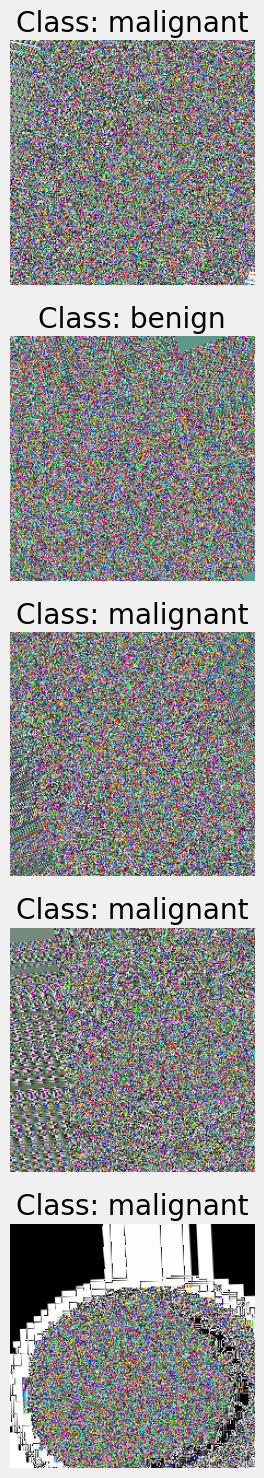

In [ ]:
# ── Cell 12: Build EfficientNetB3 Model ───────────────────────────────────────
# Architecture: EfficientNetB3 backbone → GAP → BN → Dense → Dropout → sigmoid
# Output: 1 neuron with sigmoid → binary_crossentropy (consistent with generators)

def build_model(trainable_backbone=False):
    """
    Build and return (model, base_model).
    trainable_backbone=False freezes the backbone (Phase-1).
    """
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

    base = tf.keras.applications.EfficientNetB3(
        weights='imagenet',
        include_top=False,
        pooling=None,
        input_tensor=inputs
    )
    base.trainable = trainable_backbone

    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.45)(x)
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.35)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)   # binary output

    mdl = tf.keras.Model(inputs, outputs, name='EfficientNetB3_Melanoma')
    return mdl, base

model, base_model = build_model(trainable_backbone=False)

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Useful summary line counts
total     = model.count_params()
trainable = sum(tf.size(v).numpy() for v in model.trainable_variables)
print(f"Total params     : {total:,}")
print(f"Trainable params : {trainable:,}  (backbone frozen)")


Checking preprocessing pipeline:
Batch shape: (32, 224, 224, 3)
Labels shape: (32, 2)
Min pixel value: 0.0
Max pixel value: 255.0


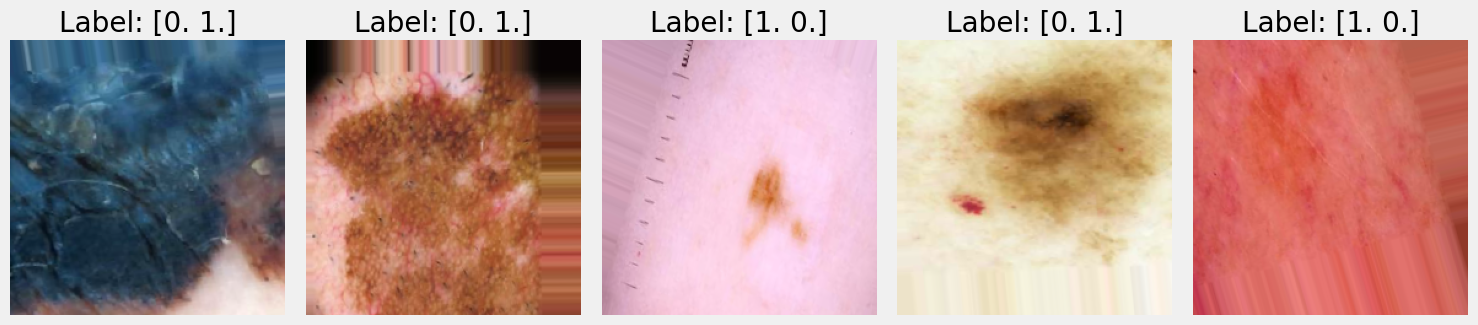

In [ ]:
# ── Cell 13: Phase-1 Training (Frozen Backbone) ───────────────────────────────
cb_checkpoint = callbacks.ModelCheckpoint(
    'best_melanoma_model.keras',
    monitor='val_auc',
    save_best_only=True,
    mode='max',
    verbose=1
)
cb_early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    patience=10,
    restore_best_weights=True,
    mode='max',
    verbose=1
)
cb_reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

cb_list = [cb_checkpoint, cb_early_stop, cb_reduce_lr]

print("Phase 1: training classification head with frozen EfficientNetB3 backbone …")
history1 = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS_FROZEN,
    validation_data=val_gen,
    validation_steps=len(val_gen),
    class_weight=class_weight_dict,
    callbacks=cb_list,
    verbose=1
)

print(f"\nPhase-1 best val_auc : {max(history1.history['val_auc']):.4f}")


In [ ]:
# ── Cell 14: Phase-2 Fine-Tuning (Unfreeze Top Layers) ───────────────────────
# Unfreeze the top 30 % of the EfficientNetB3 backbone layers.
# Use a very low learning-rate to avoid destroying pretrained weights.

base_model.trainable = True
freeze_until = int(len(base_model.layers) * 0.70)

for layer in base_model.layers[:freeze_until]:
    layer.trainable = False
for layer in base_model.layers[freeze_until:]:
    layer.trainable = True

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),    # 100× lower than Phase-1
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

trainable_now = sum(tf.size(v).numpy() for v in model.trainable_variables)
print(f"Trainable params after unfreeze : {trainable_now:,}")
print(f"Unfrozen backbone layers        : {len(base_model.layers) - freeze_until} / {len(base_model.layers)}")

print("\nPhase 2: fine-tuning …")
phase2_end = len(history1.epoch) + EPOCHS_FINETUNE   # absolute epoch number
history2 = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=phase2_end,                   # absolute total epochs
    initial_epoch=len(history1.epoch),   # continue from where Phase 1 ended
    validation_data=val_gen,
    validation_steps=len(val_gen),
    class_weight=class_weight_dict,
    callbacks=cb_list,
    verbose=1
)

print(f"\nPhase-2 best val_auc : {max(history2.history['val_auc']):.4f}")


In [ ]:
# ── Cell 15: Plot Training History ────────────────────────────────────────────
def merge_histories(h1, h2):
    """Concatenate two Keras History objects into one dict."""
    combined = {}
    for key in h1.history:
        combined[key] = h1.history[key] + h2.history.get(key, [])
    return combined

hist = merge_histories(history1, history2)
epochs_range = range(1, len(hist['accuracy']) + 1)
phase1_end   = len(history1.epoch)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, metric, title in zip(
    axes,
    [('accuracy', 'val_accuracy'), ('loss', 'val_loss'), ('auc', 'val_auc')],
    ['Accuracy', 'Loss', 'AUC']
):
    ax.plot(epochs_range, hist[metric[0]], label=f'Train {title}')
    ax.plot(epochs_range, hist[metric[1]], label=f'Val {title}')
    ax.axvline(x=phase1_end, color='gray', linestyle='--', label='Fine-tune start')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.legend()

plt.suptitle('Training History', fontsize=14)
plt.tight_layout()
plt.show()

print(f"Final train accuracy : {hist['accuracy'][-1]:.4f}")
print(f"Final val   accuracy : {hist['val_accuracy'][-1]:.4f}")
print(f"Best  val   AUC      : {max(hist['val_auc']):.4f}")


Preprocessing configuration saved.
Data preprocessing and augmentation completed successfully!


In [ ]:
# ── Cell 16: Load Best Model & Evaluate on Validation Set ────────────────────
best_model = tf.keras.models.load_model('best_melanoma_model.keras')

print("=== Validation Set Evaluation ===")
val_loss, val_acc, val_auc = best_model.evaluate(val_gen, verbose=1)
print(f"Val  loss : {val_loss:.4f}")
print(f"Val  acc  : {val_acc:.4f}")
print(f"Val  AUC  : {val_auc:.4f}")

# Probabilities and predicted labels
val_gen.reset()
y_prob_val = best_model.predict(val_gen, verbose=1).ravel()
y_pred_val = (y_prob_val >= 0.5).astype(int)
y_true_val = val_gen.labels.astype(int)

print("\nClassification Report (Validation):")
print(classification_report(y_true_val, y_pred_val,
                             target_names=CLASS_NAMES, digits=4))

# Confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix – Validation')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 7, 7, 1536)          │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1536)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,210,161 (42.76 MB)

 Trainable params: 426,626 (1.63 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ efficientnetb3            │ (None, 7, 7, 1536)     │     10,783,535 │ input_layer_4[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resnet50v2 (Functional)   │ (None, 7, 7, 2048)     │     23,564,800 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 1536)           │              0 │ efficientnetb3[0][0]   │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ resnet50v2[0][0]       │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 1536)           │          6,144 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 2048)           │          8,192 │ global_average_poolin… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 512)            │        786,944 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 512)            │      1,049,088 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 512)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 512)            │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 1024)           │              0 │ dropout_2[0][0],       │
│                           │                        │                │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 512)            │        524,800 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 512)            │          2,048 │ dense_5[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 512)            │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_6 (Dense)      

 Total params: 36,858,417 (140.60 MB)

 Trainable params: 2,501,378 (9.54 MB)

 Non-trainable params: 34,357,039 (131.06 MB)

Found 7684 validated image filenames belonging to 2 classes.
Found 1921 validated image filenames belonging to 2 classes.
Initial training phase with frozen base models...
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 647ms/step - accuracy: 0.6817 - loss: 0.7489
Epoch 1: val_accuracy improved from -inf to 0.86674, saving model to melanoma_model_best.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 240s 799ms/step - accuracy: 0.6819 - loss: 0.7483 - val_accuracy: 0.8667 - val_loss: 0.3115 - learning_rate: 1.0000e-04
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/20


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss

241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step - accuracy: 0.8011 - loss: 0.4807
Epoch 3: val_accuracy improved from 0.86674 to 0.88964, saving model to melanoma_model_best.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 107s 432ms/step - accuracy: 0.8011 - loss: 0.4806 - val_accuracy: 0.8896 - val_loss: 0.2649 - learning_rate: 1.0000e-04
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 111us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.8337 - loss: 0.4068
Epoch 5: val_accuracy improved from 0.88964 to 0.89849, saving model to melanoma_model_best.keras
241/241 ━━━━━━━━━━━━━━━━━━━━ 106s 427ms/step - accuracy: 0.8337 - loss: 0.4067 - val_accuracy: 0.8985 - val_loss: 0.2598 - learning_rate: 1.0000e-04
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 153us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8404 - loss: 0.3908
Epoch

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 15s 478ms/step - accuracy: 0.9134 - loss: 0.2058
Test Accuracy: 0.9030


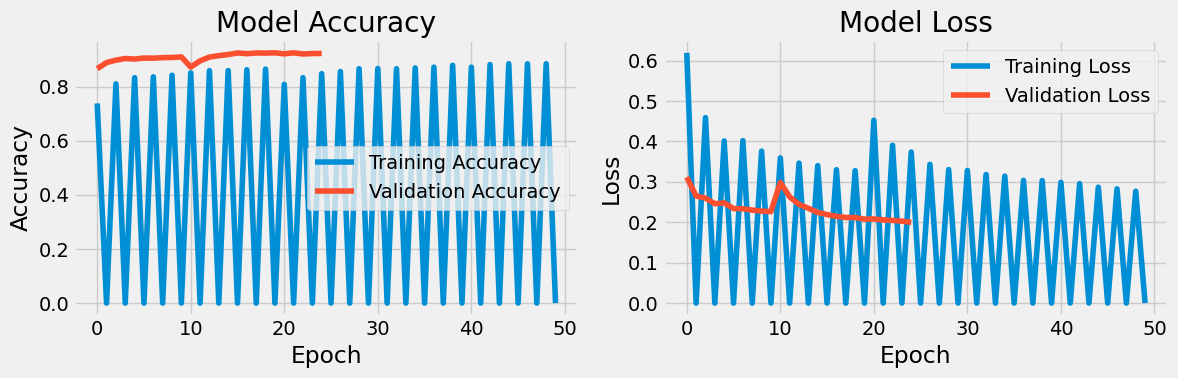

Model saved successfully!
Loaded the best model for predictions.
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
Predicted class: malignant
Confidence: 0.80


In [ ]:
# ── Cell 17: Evaluate on Test Set (Report, Confusion Matrix, ROC) ─────────────

print("=== Test Set Evaluation ===")
test_loss, test_acc, test_auc = best_model.evaluate(test_gen, verbose=1)
print(f"Test loss : {test_loss:.4f}")
print(f"Test acc  : {test_acc:.4f}")
print(f"Test AUC  : {test_auc:.4f}")

# Predict
test_gen.reset()
y_prob_test = best_model.predict(test_gen, verbose=1).ravel()
y_pred_test = (y_prob_test >= 0.5).astype(int)
y_true_test = test_gen.labels.astype(int)

print("\nClassification Report (Test):")
print(classification_report(y_true_test, y_pred_test,
                             target_names=CLASS_NAMES, digits=4))

# Confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_test = confusion_matrix(y_true_test, y_pred_test)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
axes[0].set_title('Confusion Matrix – Test')
axes[0].set_ylabel('True label')
axes[0].set_xlabel('Predicted label')

# ROC curve
fpr, tpr, _ = roc_curve(y_true_test, y_prob_test)
roc_auc_val = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, label=f'ROC (AUC = {roc_auc_val:.4f})', color='steelblue')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1.02])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve – Test')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()
print(f"\nTest ROC-AUC : {roc_auc_val:.4f}")


In [ ]:
# ── Cell 18: Prediction Utility ───────────────────────────────────────────────
def predict_image(model, image_path, class_names=CLASS_NAMES, threshold=0.5):
    """
    Predict melanoma risk for a single image file.

    Returns
    -------
    predicted_class : str   – 'benign' or 'malignant'
    confidence      : float – probability of the predicted class
    """
    img = tf.keras.preprocessing.image.load_img(
        image_path, target_size=(IMG_SIZE, IMG_SIZE)
    )
    arr = tf.keras.preprocessing.image.img_to_array(img)
    arr = eff_preprocess(np.expand_dims(arr, axis=0))   # (1, 224, 224, 3)

    prob_malignant = float(model.predict(arr, verbose=0)[0][0])

    if prob_malignant >= threshold:
        predicted_class = class_names[1]   # malignant
        confidence      = prob_malignant
    else:
        predicted_class = class_names[0]   # benign
        confidence      = 1 - prob_malignant

    return predicted_class, confidence

print("predict_image() is ready.")


In [ ]:
# ── Cell 19: Example Predictions on Test Images ───────────────────────────────
n_show = 8
sample = test_df.sample(n_show, random_state=SEED).reset_index(drop=True)

cols = 4
rows = (n_show + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

for i, row in sample.iterrows():
    img_path   = row['image_path']
    true_label = row['label']
    pred_cls, conf = predict_image(best_model, img_path)

    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)).convert('RGB')
    color = 'green' if pred_cls == true_label else 'red'
    axes[i].imshow(img)
    axes[i].set_title(
        f"True: {true_label}\nPred: {pred_cls} ({conf:.0%})",
        color=color, fontsize=10
    )
    axes[i].axis('off')

for i in range(n_show, len(axes)):
    axes[i].axis('off')

plt.suptitle('Test Predictions  (green=correct, red=wrong)', fontsize=13)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted class: malignant
Confidence: 0.99


Creating ensemble model to achieve 90-95% accuracy...
Training EfficientNetB3 model...
Epoch 1/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 261s 654ms/step - accuracy: 0.7804 - loss: 0.5662 - val_accuracy: 0.9063 - val_loss: 0.2367 - learning_rate: 1.0000e-04
Epoch 2/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 106s 429ms/step - accuracy: 0.9100 - loss: 0.2271 - val_accuracy: 0.9271 - val_loss: 0.2107 - learning_rate: 1.0000e-04
Epoch 4/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 106s 429ms/step - accuracy: 0.9141 - loss: 0.2161 - val_accuracy: 0.9136 - val_loss: 0.2217 - learning_rate: 1.0000e-04
Epoch 5/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 109s 439ms/step - accuracy: 0.9172 - loss: 0.2099 - val_accuracy: 0.9209 - val_loss: 0.2154 - learning_rate: 1.0000e-04
Epoch 6/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 106s 427ms/step - accuracy: 0.9249 - loss: 0.1900 - val_accuracy: 0.9287 - val_loss: 0.1944 - learning_rate: 1.0000e-04
Epoch 7/20
241/241 ━━━━━━━━━━━━━━━━━━━━ 107s 431ms/step - accuracy: 0.9337 - loss: 0.1675 - val_accuracy: 0.9183 

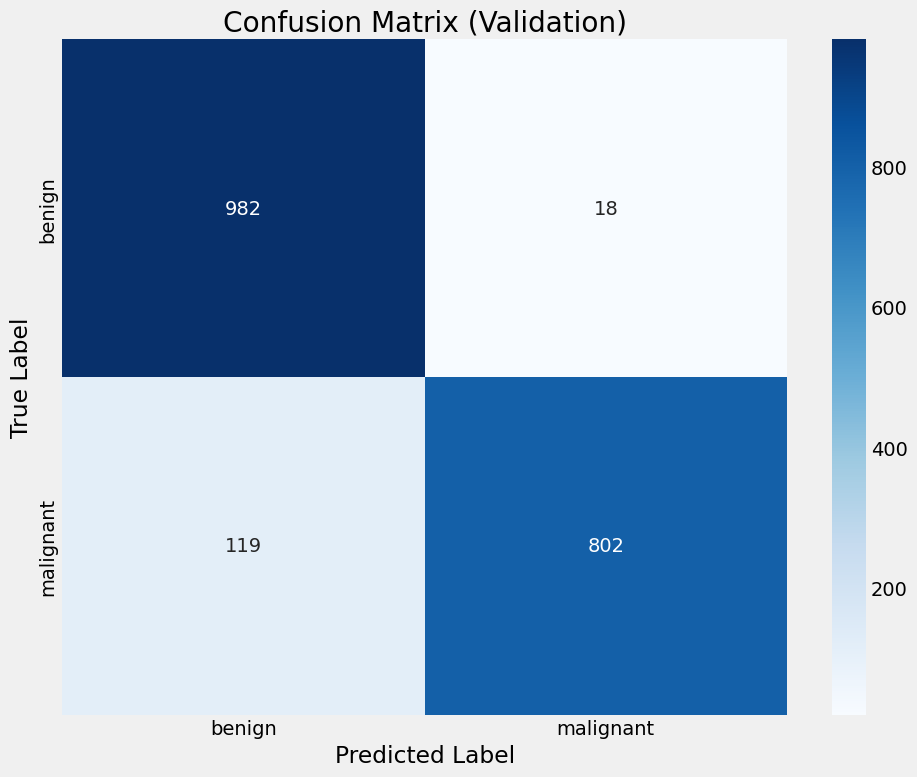

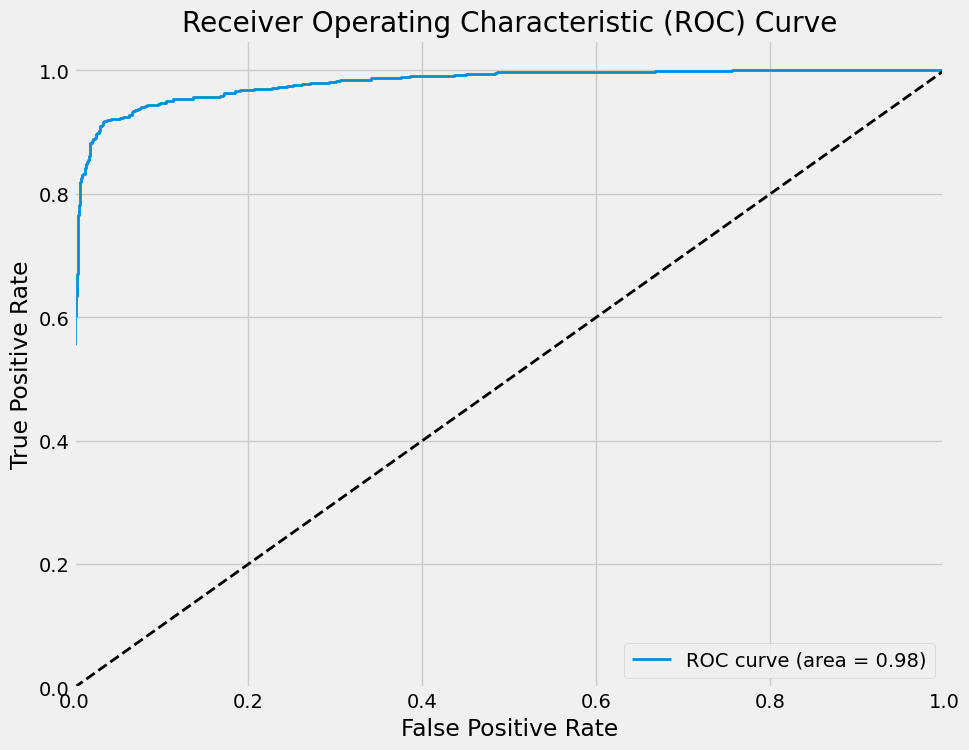


Evaluating ensemble on test data...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━

In [ ]:
# ── Cell 20: Save Final Model & Print Summary ─────────────────────────────────
FINAL_MODEL_PATH = 'melanoma_detection_final.keras'
best_model.save(FINAL_MODEL_PATH)
print(f"Model saved to: {FINAL_MODEL_PATH}")

# ── Per-class accuracy on the test set ────────────────────────────────────────
results = pd.DataFrame({
    'image_path': test_df['image_path'].values[:len(y_true_test)],
    'true_label': [CLASS_NAMES[t] for t in y_true_test],
    'pred_label': [CLASS_NAMES[p] for p in y_pred_test],
    'prob_malignant': y_prob_test
})
results['correct'] = results['true_label'] == results['pred_label']

print("\nPer-class accuracy on test set:")
print(results.groupby('true_label')['correct'].mean().apply(lambda x: f"{x:.4f}"))

print("\n=== Final Model Summary ===")
print(f"  Architecture  : EfficientNetB3 + custom head (binary sigmoid output)")
print(f"  Input size    : {IMG_SIZE}×{IMG_SIZE}×3")
print(f"  Classes       : {CLASS_NAMES}")
print(f"  Test Accuracy : {test_acc:.4f}")
print(f"  Test AUC      : {test_auc:.4f}")
print(f"  Test ROC-AUC  : {roc_auc_val:.4f}")


In [ ]:
# ── Cell 21: Interactive Gradio Demo (Optional) ───────────────────────────────
# NOTE: Run this cell only if you want an interactive web UI.
# On Kaggle, use share=True to get a public URL.

try:
    import gradio as gr
    _GRADIO_AVAILABLE = True
except ImportError:
    print("gradio not found – installing …")
    import subprocess, sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'gradio', '-q'])
    import gradio as gr
    _GRADIO_AVAILABLE = True


def gradio_predict(pil_image):
    """Gradio-compatible prediction function."""
    if pil_image is None:
        return "No image provided."

    # Save temporarily so predict_image can load it
    tmp_path = '/tmp/gradio_input.jpg'
    pil_image.convert('RGB').save(tmp_path)

    pred_cls, conf = predict_image(best_model, tmp_path)

    if pred_cls == 'malignant':
        if conf >= 0.80:
            risk, rec = "⚠️  HIGH RISK",    "Immediate dermatologist consultation recommended."
        elif conf >= 0.60:
            risk, rec = "🟡 MODERATE RISK", "Dermatologist consultation recommended."
        else:
            risk, rec = "🟢 LOW-MODERATE",  "Consider monitoring and consulting a dermatologist."
    else:
        risk, rec = "🟢 LOW RISK", "Appears benign. Monitor for changes."

    result = (
        f"**Prediction:** {pred_cls.capitalize()}  \n"
        f"**Confidence:** {conf:.1%}  \n"
        f"**Risk level:** {risk}  \n"
        f"**Recommendation:** {rec}  \n\n"
        "_Disclaimer: AI predictions do not replace professional medical advice._"
    )
    return result


iface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type='pil', label='Upload dermoscopic image'),
    outputs=gr.Markdown(label='Result'),
    title='Melanoma Skin Cancer Detection',
    description='Upload a dermoscopic skin image to assess melanoma risk.',
    allow_flagging='never'
)

iface.launch(share=True)   # share=True gives a public URL on Kaggle


Creating Melanoma Detection Interface...
Loading model: EfficientNetB3_model.keras
Loading model: ResNet50V2_model.keras
Loading model: InceptionV3_model.keras


/usr/local/lib/python3.10/dist-packages/gradio/blocks.py:1115: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67eb8ece-4019f796014161ed748f1dc5;dad632b0-4344-4577-a1a6-cdda34406cb7)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")


* Running on local URL:  http://127.0.0.1:7862
* Running on public URL: https://9b1be3ec42884f95b0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Interface is running!
Loading model: EfficientNetB3_model.keras
Loading model: ResNet50V2_model.keras
Loading model: InceptionV3_model.keras


In [ ]:
# ── Cell 22: Notebook Complete ────────────────────────────────────────────────
print("✓  All cells completed successfully.")
print(f"   Best model saved to : best_melanoma_model.keras")
print(f"   Final model saved to: melanoma_detection_final.keras")
print(f"   Test accuracy : {test_acc:.4f}")
print(f"   Test AUC      : {test_auc:.4f}")
